In [1]:
conda init

no change     /Users/aesthetic/opt/anaconda3/condabin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda
no change     /Users/aesthetic/opt/anaconda3/bin/conda-env
no change     /Users/aesthetic/opt/anaconda3/bin/activate
no change     /Users/aesthetic/opt/anaconda3/bin/deactivate
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.sh
no change     /Users/aesthetic/opt/anaconda3/etc/fish/conf.d/conda.fish
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/Conda.psm1
no change     /Users/aesthetic/opt/anaconda3/shell/condabin/conda-hook.ps1
no change     /Users/aesthetic/opt/anaconda3/lib/python3.8/site-packages/xontrib/conda.xsh
no change     /Users/aesthetic/opt/anaconda3/etc/profile.d/conda.csh
no change     /Users/aesthetic/.bash_profile
No action taken.

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install alpha_vantage pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint
from alpha_vantage.techindicators import TechIndicators
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt 
import sys
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report


import numpy as np



In [4]:
# Obtaining stock data from alpha vantage 
sym='AAPL'




ticker_list=['MS', 'BT-A.L', 'TSLA', 'PFE' ]
# 'BT-A.L', 'TSLA', 'PFE'
column_names=['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 
               '7. dividend amount', '8. split coefficient', 'Ticker']
#obtains stock data from the previous day date to 2018-11-29


def stock_data(sym):
    ts = TimeSeries(key='SUXOFAIGXM6HEP9Y', output_format='pandas')
    data, meta_data = ts.get_daily_adjusted(symbol=sym, outputsize='full')
    data_date_changed = data[:'2019-01-01']
    data_date_changed['Ticker']= sym
    return data_date_changed


data_dated = pd.DataFrame(columns = column_names)


for ticker in ticker_list:
    data_dated = data_dated.append(stock_data(ticker), sort=False)


<ipython-input-4-50d4edb1b606>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_date_changed['Ticker']= sym


# Identify Anomalies

In [5]:
print('The shape of our data is:', data_dated.shape)

The shape of our data is: (2139, 9)


In [6]:
data_dated.isna().any()

1. open                 False
2. high                 False
3. low                  False
4. close                False
5. adjusted close       False
6. volume               False
7. dividend amount      False
8. split coefficient    False
Ticker                  False
dtype: bool

In [7]:
data_dated.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker
2021-02-12,73.88,75.020,73.88,74.61,74.61,7281192.0,0.0,1.0,MS
2021-02-11,74.33,74.770,72.78,73.72,73.72,6972883.0,0.0,1.0,MS
2021-02-10,74.60,74.865,73.55,74.33,74.33,7180859.0,0.0,1.0,MS
2021-02-09,73.90,74.680,73.37,74.24,74.24,7323686.0,0.0,1.0,MS
2021-02-08,73.64,74.290,73.40,74.23,74.23,9018095.0,0.0,1.0,MS


In [8]:

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

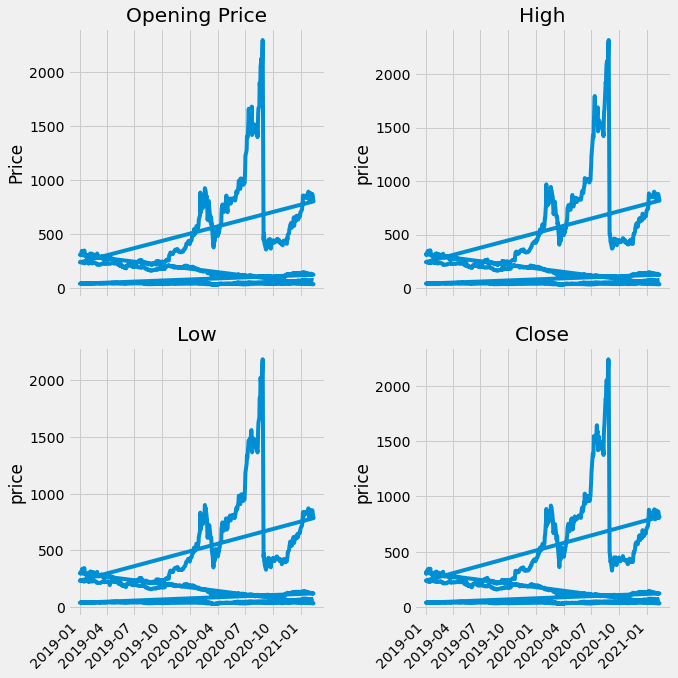

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# opening price
ax1.plot(data_dated.index, data_dated['1. open'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('Opening Price')


ax2.plot(data_dated.index, data_dated['2. high'])
ax2.set_xlabel(''); ax2.set_ylabel('price'); ax2.set_title('High')


ax3.plot(data_dated.index, data_dated['3. low'])
ax3.set_xlabel(''); ax3.set_ylabel('price'); ax3.set_title('Low')

ax4.plot(data_dated.index, data_dated['4. close'])
ax4.set_xlabel(''); ax4.set_ylabel('price'); ax4.set_title('Close')


plt.tight_layout(pad=2)


In [10]:
data_dated[data_dated.duplicated()]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker


One Hot Encoding 

# data_dated.tail()

In [11]:
data_dated['date']= data_dated.index

In [12]:
data_dated.sort_index(inplace=True)
data_dated.sort_values(by = ['Ticker','date'], inplace = True)


data_dated['change_in_price']= data_dated['4. close'].diff()

In [13]:
mask = data_dated['Ticker'] != data_dated['Ticker'].shift(1)

data_dated['change_in_price']= np.where(mask==True, np.nan, data_dated['change_in_price'])

data_dated[data_dated.isna().any(axis=1)]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price
2019-01-02,237.00,242.20,233.25,240.00,220.802700,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN
2019-01-02,39.02,40.72,38.76,40.40,37.935801,10648013.0,0.0,1.0,MS,2019-01-02,NaN
2019-01-02,43.12,43.50,42.64,43.25,37.587547,25076212.0,0.0,1.0,PFE,2019-01-02,NaN
2019-01-02,306.10,315.13,298.80,310.12,62.024000,11658600.0,0.0,1.0,TSLA,2019-01-02,NaN


In [14]:
data_dated['day'] = data_dated.index.day
data_dated['month'] = data_dated.index.month
data_dated['year'] = data_dated.index.year

In [15]:
data_dated.reset_index(inplace=True)

In [16]:
data_dated.head(20)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price,day,month,year
0,2019-01-02,237.00,242.20,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN,2,1,2019
1,2019-01-03,240.10,242.60,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,2019-01-03,0.10,3,1,2019
2,2019-01-04,241.00,241.90,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,2019-01-04,-2.75,4,1,2019
3,2019-01-07,239.95,242.00,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,2019-01-07,0.60,7,1,2019
4,2019-01-08,237.75,238.90,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,2019-01-08,-6.95,8,1,2019
5,2019-01-09,232.30,234.85,230.550,232.50,213.9026,25148123.0,0.0,1.0,BT-A.L,2019-01-09,1.50,9,1,2019
6,2019-01-10,232.70,234.70,231.850,233.55,214.8686,17643904.0,0.0,1.0,BT-A.L,2019-01-10,1.05,10,1,2019
7,2019-01-11,233.75,236.35,232.500,233.05,214.4086,46248643.0,0.0,1.0,BT-A.L,2019-01-11,-0.50,11,1,2019
8,2019-01-14,232.85,233.15,228.050,228.60,210.3146,50697635.0,0.0,1.0,BT-A.L,2019-01-14,-4.45,14,1,2019
9,2019-01-15,231.65,232.25,229.100,229.95,211.5566,17775775.0,0.0,1.0,BT-A.L,2019-01-15,1.35,15,1,2019


In [ ]:
days_out= 90

data_dated_smoothed = data_dated.groupby(['Ticker'])[['1. open','2. high','3. low','4. close','6. volume','day', 'month', 'year']].transform(lambda x: x.ewm(span = days_out).mean())

smoothed_df = pd.concat([data_dated[['Ticker','date']], data_dated_smoothed], axis=1, sort=False)

In [ ]:
# define the number of days out you want to predict
days_out = 90

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('Ticker')['4. close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

In [17]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = data_dated[['Ticker','change_in_price']].copy(), data_dated[['Ticker','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
data_dated['down_days'] = down_df['change_in_price']
data_dated['up_days'] = up_df['change_in_price']
data_dated['RSI'] = relative_strength_index

# Display the head.
data_dated.head(30)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,date,change_in_price,day,month,year,down_days,up_days,RSI
0,2019-01-02,237.00,242.20,233.2500,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,2019-01-02,NaN,2,1,2019,NaN,NaN,NaN
1,2019-01-03,240.10,242.60,237.5500,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,2019-01-03,0.10,3,1,2019,0.00,0.10,100.000000
2,2019-01-04,241.00,241.90,236.4500,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,2019-01-04,-2.75,4,1,2019,2.75,0.00,3.055229
3,2019-01-07,239.95,242.00,237.0660,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,2019-01-07,0.60,7,1,2019,0.00,0.60,22.073676
4,2019-01-08,237.75,238.90,229.4000,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,2019-01-08,-6.95,8,1,2019,6.95,0.00,6.094339
5,2019-01-09,232.30,234.85,230.5500,232.50,213.9026,25148123.0,0.0,1.0,BT-A.L,2019-01-09,1.50,9,1,2019,0.00,1.50,20.437556
6,2019-01-10,232.70,234.70,231.8500,233.55,214.8686,17643904.0,0.0,1.0,BT-A.L,2019-01-10,1.05,10,1,2019,0.00,1.05,29.175052
7,2019-01-11,233.75,236.35,232.5000,233.05,214.4086,46248643.0,0.0,1.0,BT-A.L,2019-01-11,-0.50,11,1,2019,0.50,0.00,27.514801
8,2019-01-14,232.85,233.15,228.0500,228.60,210.3146,50697635.0,0.0,1.0,BT-A.L,2019-01-14,-4.45,14,1,2019,4.45,0.00,17.366218
9,2019-01-15,231.65,232.25,229.1000,229.95,211.5566,17775775.0,0.0,1.0,BT-A.L,2019-01-15,1.35,15,1,2019,0.00,1.35,26.815134


In [18]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = data_dated[['Ticker','3. low']].copy(), data_dated[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((data_dated['4. close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
data_dated['low_14'] = low_14
data_dated['high_14'] = high_14
data_dated['k_percent'] = k_percent

# Display the head.
data_dated.head(5)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,change_in_price,day,month,year,down_days,up_days,RSI,low_14,high_14,k_percent
0,2019-01-02,237.00,242.2,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,...,NaN,2,1,2019,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,240.10,242.6,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,...,0.10,3,1,2019,0.00,0.1,100.000000,NaN,NaN,NaN
2,2019-01-04,241.00,241.9,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,...,-2.75,4,1,2019,2.75,0.0,3.055229,NaN,NaN,NaN
3,2019-01-07,239.95,242.0,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,...,0.60,7,1,2019,0.00,0.6,22.073676,NaN,NaN,NaN
4,2019-01-08,237.75,238.9,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,...,-6.95,8,1,2019,6.95,0.0,6.094339,NaN,NaN,NaN


In [19]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = data_dated[['Ticker','3. low']].copy(), data_dated[['Ticker','2. high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Ticker')['3. low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['2. high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - data_dated['4. close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
data_dated['r_percent'] = r_percent

# Display the head.
data_dated.head(5)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,day,month,year,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,2019-01-02,237.00,242.2,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,...,2,1,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,240.10,242.6,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,...,3,1,2019,0.00,0.1,100.000000,NaN,NaN,NaN,NaN
2,2019-01-04,241.00,241.9,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,...,4,1,2019,2.75,0.0,3.055229,NaN,NaN,NaN,NaN
3,2019-01-07,239.95,242.0,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,...,7,1,2019,0.00,0.6,22.073676,NaN,NaN,NaN,NaN
4,2019-01-08,237.75,238.9,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,...,8,1,2019,6.95,0.0,6.094339,NaN,NaN,NaN,NaN


In [20]:
# Calculate the MACD
ema_26 = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
data_dated['MACD'] = macd
data_dated['MACD_EMA'] = ema_9_macd

# Print the head.
data_dated.head(5)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,year,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,2019-01-02,237.00,242.2,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,...,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2019-01-03,240.10,242.6,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,...,2019,0.00,0.1,100.000000,NaN,NaN,NaN,NaN,0.002244,0.001246
2,2019-01-04,241.00,241.9,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,...,2019,2.75,0.0,3.055229,NaN,NaN,NaN,NaN,-0.082419,-0.033042
3,2019-01-07,239.95,242.0,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,...,2019,0.00,0.6,22.073676,NaN,NaN,NaN,NaN,-0.097242,-0.054790
4,2019-01-08,237.75,238.9,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,...,2019,6.95,0.0,6.094339,NaN,NaN,NaN,NaN,-0.379806,-0.151475


In [21]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
data_dated['Price_Rate_Of_Change'] = data_dated.groupby('Ticker')['4. close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
data_dated.head(5)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2019-01-02,237.00,242.2,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2019-01-03,240.10,242.6,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,...,0.00,0.1,100.000000,NaN,NaN,NaN,NaN,0.002244,0.001246,NaN
2,2019-01-04,241.00,241.9,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,...,2.75,0.0,3.055229,NaN,NaN,NaN,NaN,-0.082419,-0.033042,NaN
3,2019-01-07,239.95,242.0,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,...,0.00,0.6,22.073676,NaN,NaN,NaN,NaN,-0.097242,-0.054790,NaN
4,2019-01-08,237.75,238.9,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,...,6.95,0.0,6.094339,NaN,NaN,NaN,NaN,-0.379806,-0.151475,NaN


In [22]:
def obv(group):

    # Grab the volume and close column.
    volume = group['6. volume']
    change = group['4. close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = data_dated.groupby('Ticker').apply(obv)

# add to the data frame, but drop the old index, before adding it.
data_dated['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
data_dated.head(5)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,2019-01-02,237.00,242.2,233.250,240.00,220.8027,20278421.0,0.0,1.0,BT-A.L,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0
1,2019-01-03,240.10,242.6,237.550,240.10,220.8947,13975097.0,0.0,1.0,BT-A.L,...,0.1,100.000000,NaN,NaN,NaN,NaN,0.002244,0.001246,NaN,13975097.0
2,2019-01-04,241.00,241.9,236.450,237.35,218.3646,19484073.0,0.0,1.0,BT-A.L,...,0.0,3.055229,NaN,NaN,NaN,NaN,-0.082419,-0.033042,NaN,-5508976.0
3,2019-01-07,239.95,242.0,237.066,237.95,218.9167,15507525.0,0.0,1.0,BT-A.L,...,0.6,22.073676,NaN,NaN,NaN,NaN,-0.097242,-0.054790,NaN,9998549.0
4,2019-01-08,237.75,238.9,229.400,231.00,212.5226,26557234.0,0.0,1.0,BT-A.L,...,0.0,6.094339,NaN,NaN,NaN,NaN,-0.379806,-0.151475,NaN,-16558685.0


In [23]:
# # Create a column we wish to predict
# '''
#     In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
#     In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
# '''

# # Group by the `Symbol` column, then grab the `Close` column.
# close_groups = data_dated.groupby('Ticker')['4. close']

# # Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
# close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# # add the data to the main dataframe.
# data_dated['Prediction'] = close_groups

# # for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
# data_dated.loc[data_dated['Prediction'] == 0.0] = 1.0

# # print the head
# data_dated.head(5)

# # OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# # price_data.to_csv('final_metrics.csv')

In [24]:
data_dated.tail(10)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
2129,2021-02-01,814.290,842.0000,795.5601,839.81,839.81,25391385.0,0.0,1.0,TSLA,...,46.28,53.003695,780.1,900.4,49.634248,-50.365752,43.205316,54.331398,-0.005612,1.632802e+09
2130,2021-02-02,844.680,880.5000,842.2006,872.79,872.79,23998098.0,0.0,1.0,TSLA,...,32.98,60.798348,780.1,900.4,77.049044,-22.950956,43.066709,52.078460,0.026268,1.656800e+09
2131,2021-02-03,877.020,878.0800,853.0646,854.69,854.69,18343510.0,0.0,1.0,TSLA,...,0.00,55.019690,780.1,900.4,62.003325,-37.996675,41.023451,49.867458,0.011479,1.638457e+09
2132,2021-02-04,855.000,856.5000,833.4200,849.99,849.99,15812661.0,0.0,1.0,TSLA,...,0.00,53.496248,780.1,900.4,58.096426,-41.903574,38.580175,47.610002,0.003957,1.622644e+09
2133,2021-02-05,845.000,864.7700,838.9700,852.23,852.23,18566637.0,0.0,1.0,TSLA,...,2.24,54.193727,780.1,900.4,59.958437,-40.041563,36.404957,45.368993,-0.032436,1.641211e+09
2134,2021-02-08,869.670,877.7700,854.7500,863.42,863.42,20161719.0,0.0,1.0,TSLA,...,11.19,57.838640,780.1,900.4,69.260183,-30.739817,35.178505,43.330895,-0.022274,1.661372e+09
2135,2021-02-09,855.120,859.8000,841.7500,849.46,849.46,15027305.0,0.0,1.0,TSLA,...,0.00,51.894527,780.1,900.4,57.655860,-42.344140,32.703096,41.205335,-0.017011,1.646345e+09
2136,2021-02-10,843.635,844.8200,800.0200,804.82,804.82,35723444.0,0.0,1.0,TSLA,...,0.00,37.626843,780.1,900.4,20.548628,-79.451372,26.829963,38.330261,-0.036640,1.610622e+09
2137,2021-02-11,812.440,829.8799,801.7250,811.66,811.66,21622753.0,0.0,1.0,TSLA,...,6.84,40.518163,780.1,900.4,26.234414,-73.765586,22.468392,35.157887,0.022847,1.632244e+09
2138,2021-02-12,801.260,817.3300,785.3306,816.12,816.12,23768313.0,0.0,1.0,TSLA,...,4.46,42.522732,780.1,895.9,31.105354,-68.894646,19.150940,31.956498,-0.028209,1.656013e+09


In [25]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(data_dated.shape[0], data_dated.shape[1]))

# Any row that has a `NaN` value will be dropped.
data_dated = data_dated.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(data_dated.shape[0], data_dated.shape[1]))

# Print the head.
data_dated.head()

Before NaN Drop we have 2139 rows and 26 columns
After NaN Drop we have 2087 rows and 26 columns


,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2019-01-21,238.10,240.75,235.45,238.00,218.9627,14523400.0,0.0,1.0,BT-A.L,...,0.00,60.390476,225.284,242.6,73.434973,-26.565027,-0.039403,-0.489356,0.030303,-11321942.0
14,2019-01-22,238.05,241.40,236.45,238.00,218.9627,18538398.0,0.0,1.0,BT-A.L,...,0.00,60.390476,225.284,242.6,73.434973,-26.565027,0.205613,-0.345293,0.023656,-11321942.0
15,2019-01-23,236.85,240.40,233.30,237.90,218.8707,16839418.0,0.0,1.0,BT-A.L,...,0.00,59.949808,225.284,242.0,75.472601,-24.527399,0.382881,-0.195440,0.018626,-28161360.0
16,2019-01-24,237.95,238.85,234.75,236.25,217.3527,16914074.0,0.0,1.0,BT-A.L,...,0.00,52.637268,225.284,242.0,65.601819,-34.398181,0.411211,-0.071315,0.013731,-45075434.0
17,2019-01-25,236.40,237.40,233.40,236.40,217.4907,21481208.0,0.0,1.0,BT-A.L,...,0.15,53.235612,225.284,241.4,68.974932,-31.025068,0.437317,0.032278,0.034121,-23594226.0


In [26]:
# Use numpy to convert to arrays
import numpy as np
import datetime as dt
# One-hot encode the data using pandas get_dummies
# data_dated = pd.get_dummies(data_dated)

true_data=data_dated
# Labels are the values we want to predict
labels = np.array(data_dated['4. close'])

# dt.datetime.strftime(smoothed_df['date'], '%m%d%H')
# # Remove the labels from the features
# # axis 1 refers to the columns
data_dated= data_dated[['day', 'month', 'year','RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]

# # Saving feature names for later use
data_dated_list = list(data_dated.columns)

# Convert to numpy array
data_dated = np.array(data_dated)

 


In [27]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_dated, labels, test_size = 0.25, random_state = 42)

In [28]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (1565, 9)
Training Labels Shape: (1565,)
Testing Features Shape: (522, 9)
Testing Labels Shape: (522,)


In [29]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);


In [30]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 6.96 degrees.


In [31]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 95.09 %.


In [32]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(data_dated_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MACD                 Importance: 0.88
Variable: On Balance Volume    Importance: 0.05
Variable: month                Importance: 0.03
Variable: year                 Importance: 0.02
Variable: day                  Importance: 0.0
Variable: RSI                  Importance: 0.0
Variable: k_percent            Importance: 0.0
Variable: r_percent            Importance: 0.0
Variable: Price_Rate_Of_Change Importance: 0.0


In [33]:
true_data.head(10)

,index,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Ticker,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
13,2019-01-21,238.10,240.75,235.45,238.00,218.9627,14523400.0,0.0,1.0,BT-A.L,...,0.00,60.390476,225.284,242.6,73.434973,-26.565027,-0.039403,-0.489356,0.030303,-11321942.0
14,2019-01-22,238.05,241.40,236.45,238.00,218.9627,18538398.0,0.0,1.0,BT-A.L,...,0.00,60.390476,225.284,242.6,73.434973,-26.565027,0.205613,-0.345293,0.023656,-11321942.0
15,2019-01-23,236.85,240.40,233.30,237.90,218.8707,16839418.0,0.0,1.0,BT-A.L,...,0.00,59.949808,225.284,242.0,75.472601,-24.527399,0.382881,-0.195440,0.018626,-28161360.0
16,2019-01-24,237.95,238.85,234.75,236.25,217.3527,16914074.0,0.0,1.0,BT-A.L,...,0.00,52.637268,225.284,242.0,65.601819,-34.398181,0.411211,-0.071315,0.013731,-45075434.0
17,2019-01-25,236.40,237.40,233.40,236.40,217.4907,21481208.0,0.0,1.0,BT-A.L,...,0.15,53.235612,225.284,241.4,68.974932,-31.025068,0.437317,0.032278,0.034121,-23594226.0
18,2019-01-28,235.35,240.35,234.05,236.00,217.1227,16641931.0,0.0,1.0,BT-A.L,...,0.00,51.243695,225.284,241.4,66.492926,-33.507074,0.426401,0.112255,0.026310,-40236157.0
19,2019-01-29,236.15,239.35,234.30,234.30,215.5587,19319500.0,0.0,1.0,BT-A.L,...,0.00,43.298901,225.284,241.4,55.944403,-44.055597,0.302029,0.150652,0.028534,-59555657.0
20,2019-01-30,235.00,236.35,231.25,234.00,215.2826,21472302.0,0.0,1.0,BT-A.L,...,0.00,41.973824,225.284,241.4,54.082899,-45.917101,0.182467,0.157075,0.009273,-81027959.0
21,2019-01-31,224.90,238.00,221.00,232.40,213.8106,57753695.0,0.0,1.0,BT-A.L,...,0.00,35.321802,221.000,241.4,55.882353,-44.117647,-0.019595,0.121478,-0.027208,-138781654.0
22,2019-02-01,230.35,233.01,228.20,230.00,211.6026,26032151.0,0.0,1.0,BT-A.L,...,0.00,27.718751,221.000,241.4,44.117647,-55.882353,-0.339122,0.028811,-0.033613,-164813805.0


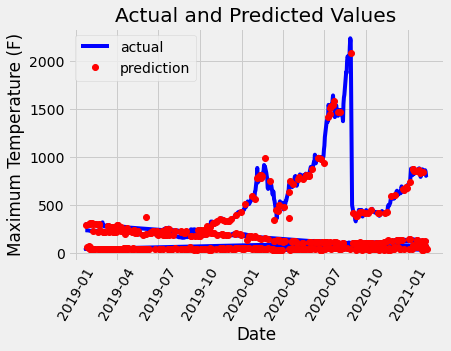

In [34]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = data_dated[:, data_dated_list.index('month')]
days = data_dated[:, data_dated_list.index('day')]
years = data_dated[:, data_dated_list.index('year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dates of predictions
months = test_features[:, data_dated_list.index('month')]
days = test_features[:, data_dated_list.index('day')]
years = test_features[:, data_dated_list.index('year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]


# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['4. close'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');